In [1]:
# %pip install river==0.10.1
# %pip install pmdarima
# %pip install statsforecast
# %pip install -U scikit-multiflow
# %pip install pysr

In [2]:
from XTSTree.XTSTreePageHinkley import XTSTreePageHinkley
from plot import plot
import math
import time
import numpy as np
import random
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA as statsARIMA
import pysr
from collections.abc import Iterable

Pegando série e criando a árvore

In [3]:
from warnings import simplefilter
def clear_warns():
	simplefilter("ignore", category=RuntimeWarning)
	simplefilter("ignore", category=UserWarning)

Função que pega média e desvio padrão e diferença da soma das diferenças

In [4]:
def stats(series):
  desvio = np.std(series)
  media = np.mean(series)
  med_diff = np.mean(np.diff(series))
  return desvio, media, med_diff

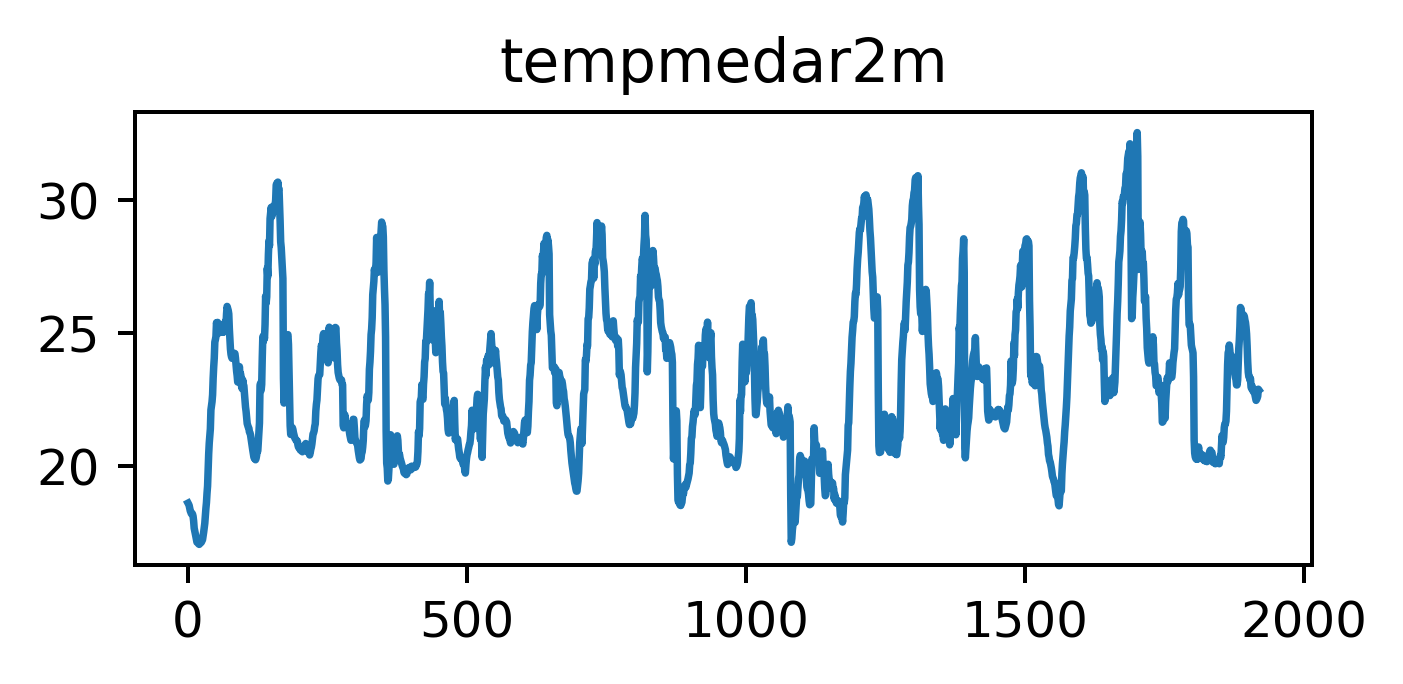

5.294029787302023
(-8.157092978822623, 9.35646499681725e-13, 20, 1899, {'1%': -3.4337982155955413, '5%': -2.8630631915206006, '10%': -2.5675808895205785}, 2292.5391613078746)
Criando splits
Splits achados em 0.33943200000794604: 


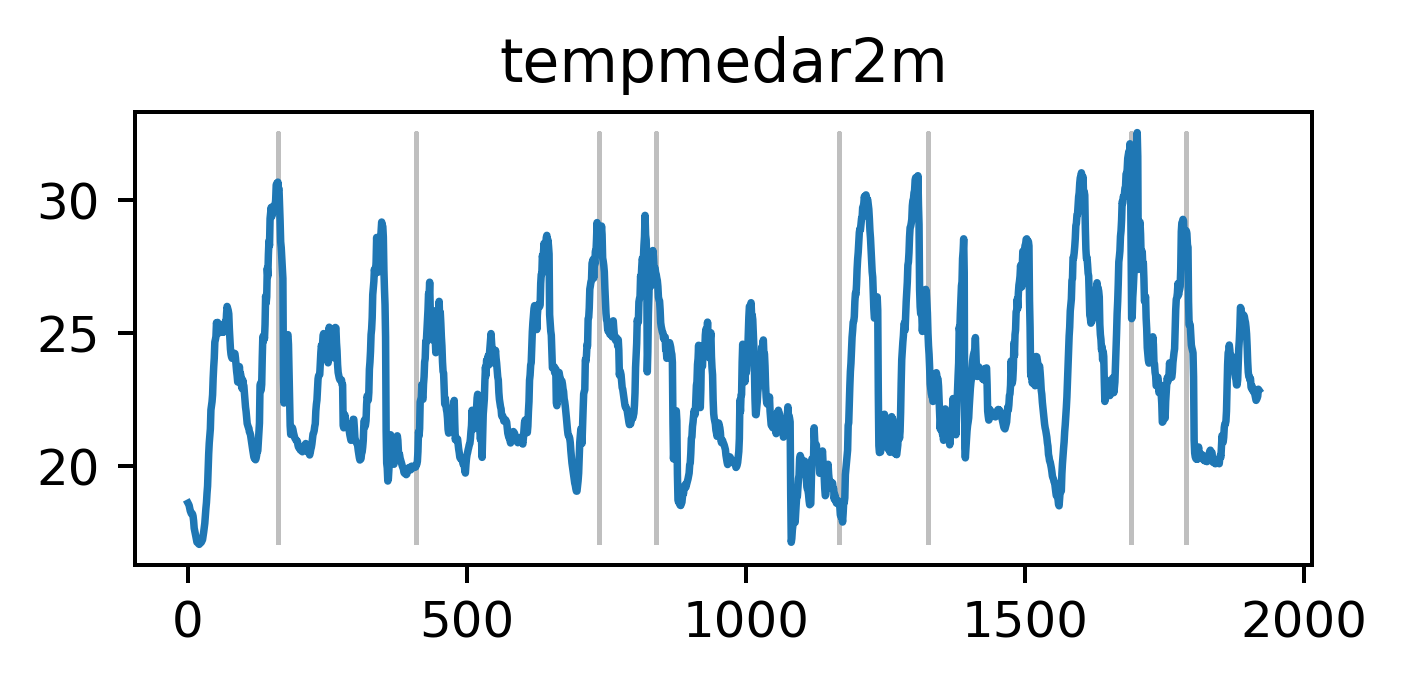

In [5]:
from statsmodels.tsa.stattools import adfuller
# series_path = '/content/drive/MyDrive/IDR-PR/Dados/por estacao/23025122/export_automaticas_23025122_tempsolocm40cm.csv'
feature = 'tempmedar2m'
# ventodir10m
series_path = f'../../../Dados/por estacao/23025122/export_automaticas_23025122_{feature}.csv'
clear_warns()

series_len = 20 * 96

series = pd.read_csv(series_path, nrows=series_len)

date_dict = {}
for i, date in enumerate(series.groupby(['date'])):
  date_dict[date[0]] = i

series['date'] = [date_dict[date] for date in series['date'].to_list()]
series['hour'] = [(int(int(h.split(':')[1])/15) + int(h.split(':')[0]) * 4) * 15 for h in series['hour'].to_list()]
series[feature] = series[feature].where(np.isfinite, series[feature].shift(fill_value=0))

adf = 0.05

plot(series[feature], title=feature)
adf_test = adfuller(series[feature])
print(adf_test[4][f'{int(adf*100)}%'] - adf_test[0])
print(adf_test)
print('Criando splits')

t = time.perf_counter()
xtstree = XTSTreePageHinkley(stop_condition='adf', stop_val=adf, min_dist=100, max_iter=100)
series.head()
xtstree.create_splits(series[feature])
print(f'Splits achados em {time.perf_counter() - t}: ')
plot(series[feature], divisions=xtstree.cut_points(), title=feature)

Testes

Arima

In [11]:
from pmdarima.arima import ndiffs, nsdiffs
from statsforecast.arima import arima, AutoARIMA
from sklearn.metrics import mean_squared_error as mse

In [12]:
mse_perc = 0.4
def apply_arima(series):
  preds = AutoARIMA(period=96,
                    # d=ndiffs(series, test='adf'),
                    # D=nsdiffs(series, m=96),
                    stepwise=True
									).fit(series).predict_in_sample()['mean']
  err = mse(series[int(len(series)*(1-mse_perc)):], preds[int(len(preds)*(1-mse_perc)):])
  return list(preds), err

def seq_data(data, window_size=96):
  data_X = []
  data_Y = []
  for i in range(len(data) - (len(data) % window_size) - window_size):
    data_X.append(data[i:i+window_size])
    try:
      data_Y.append(data[i+window_size])
    except:
      (i+window_size)
  return np.array(data_X), np.array(data_Y)

In [13]:
print(f'Aplicando AutoARIMA na série toda')
t = time.perf_counter()
pred_full, _ = apply_arima(np.array(series[feature]))
print(f'AutoARIMA aplicado em {time.perf_counter() - t} segundos')

errs_full_by_cut = []
cut_points = [0] + xtstree.cut_points() + [len(series)]
for i, cut_pos in enumerate(cut_points):
  if i == 0:
    continue
  errs_full_by_cut.append(
    mse(
      series[feature][int(((cut_pos - cut_points[i-1])*(1-mse_perc)) + cut_points[i-1]):cut_pos],
      pred_full[int(((cut_pos - cut_points[i-1])*(1-mse_perc)) + cut_points[i-1]):cut_pos]
    )
  )


Aplicando AutoARIMA na série toda
AutoARIMA aplicado em 67.8164184000052 segundos


In [22]:
{
  'serie': serie,
	'1a': [ini, fim],
	'1b': [ini, fim],
}
# serie 1-100
{
	'0': [serie],
	'1': [serie[:50], serie[50:]],
	'2': [serie[:25], serie[25:50], serie[50:]],
	'3': [serie[:17], serie[17:25], serie[25:50], serie[50:]]
}
{
	'0': [100],
	'1': [50, 50],
	'2': [25, 25, 50],
	'3': [17, 8, 25, 50]
}

[
	{'0': [839]},
	{'1': [409]},
	{'1': [1326]},
	{'2': [162]},
	{'2': [737]},
	{'2': [1167]},
	{'2': [1689]},
	{'3': [1788]},
]

[162, 409, 737, 839, 1167, 1326, 1689, 1788]

In [14]:
pred_cuts = []
errs_cuts_by_cut = []
print('Aplicando AutoARIMA nos cortes da árvore')
t = time.perf_counter()
for s in xtstree.cut_series(series[feature]):
  pred, err = apply_arima(np.array(s))
  pred_cuts = pred_cuts + pred
  errs_cuts_by_cut.append(err)
print(f'AutoARIMA aplicado em {time.perf_counter() - t} segundos')

Aplicando AutoARIMA nos cortes da árvore
AutoARIMA aplicado em 67.69302809998044 segundos


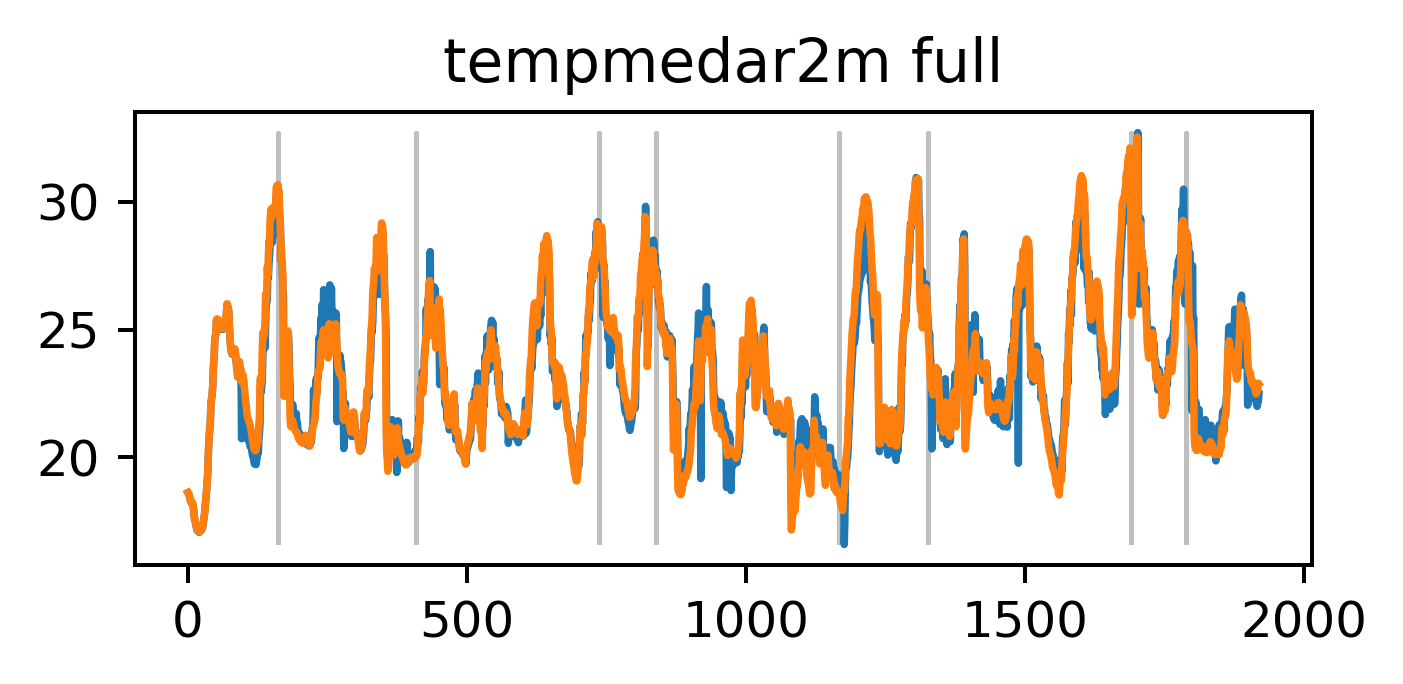

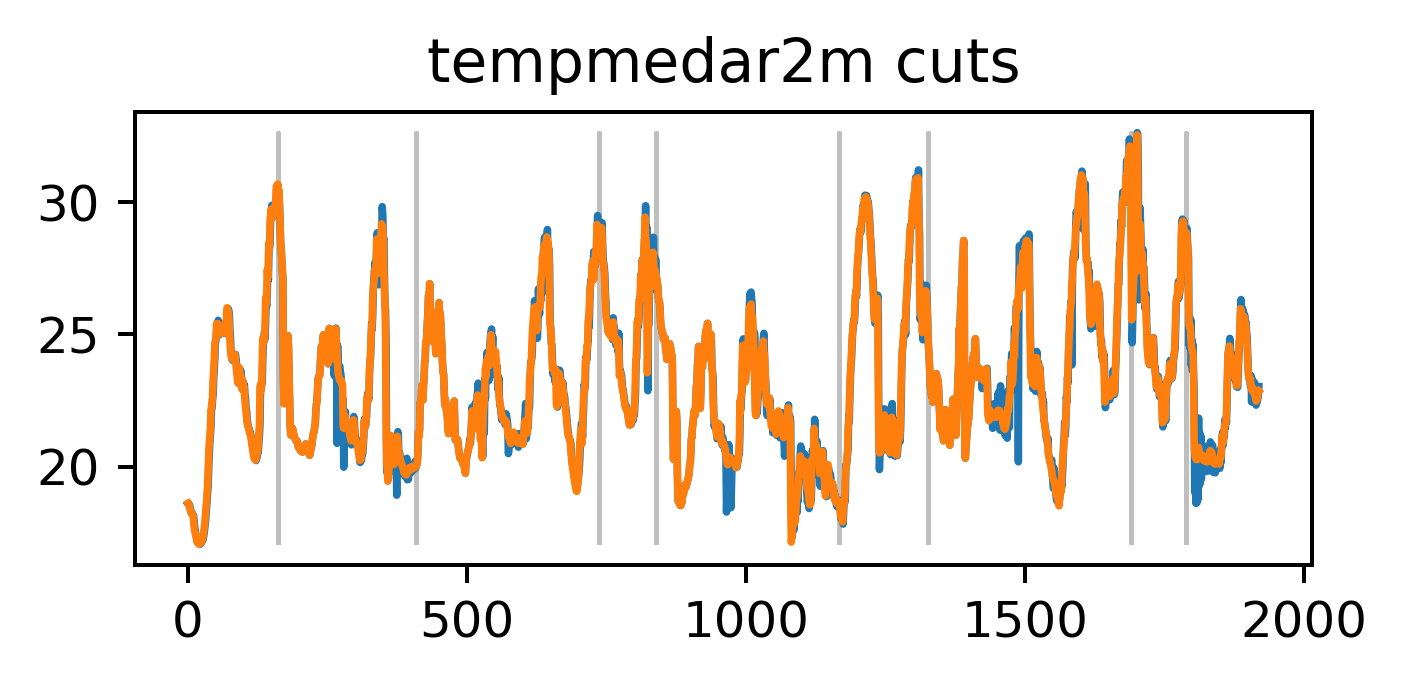

In [15]:
plot(pred_full, sec_plots=[series[feature]], title=f'{feature} full', divisions=xtstree.cut_points())
plot(pred_cuts, sec_plots=[series[feature]], title=f'{feature} cuts', divisions=xtstree.cut_points())

In [16]:
print(f'Erro nos últimos {mse_perc * 100}% de cada corte')
print('Erro dos cortes / Erro série completa')
print(list(zip(errs_cuts_by_cut,errs_full_by_cut)))

err_full = mse(series[feature][int(len(series)*(1-mse_perc)):], pred_full[int(len(pred_full)*(1-mse_perc)):])
err_cuts = mse(series[feature][int(len(series)*(1-mse_perc)):], pred_cuts[int(len(pred_cuts)*(1-mse_perc)):])
print('Erro total')
print(f'Erro cortes: {err_cuts}, Erro completa: {err_full}')

Erro nos últimos 40.0% de cada corte
Erro dos cortes / Erro série completa
[(0.15270880308416793, 0.633701178091539), (0.2559113605247332, 0.4025183479385981), (0.2074405699667729, 0.33837417830138933), (0.6377618255733277, 0.6090847265791343), (0.20614782008384788, 0.4859977705160424), (0.2573141879651289, 0.3788003285171761), (0.23531693403122617, 0.5916621480390448), (0.13462300599715465, 0.6518599776429631), (0.0655087325961081, 0.5596738070175559)]
Erro total
Erro cortes: 0.29194525932543497, Erro completa: 0.8179649879145656


Regressão Linear - Série toda e Divisões

In [17]:
def seq_data(data, window_size=96):
  data_X = []
  data_Y = []
  for i in range(len(data) - (len(data) % window_size) - window_size):
    data_X.append(data[i:i+window_size])
    try:
      data_Y.append(data[i+window_size])
    except:
      (i+window_size)
  return np.array(data_X), np.array(data_Y)


def sr_on_series(X: pd.DataFrame, y: Iterable):
  model = pysr.PySRRegressor(
    binary_operators=['+', '-', '*', '/', 'pow'],
    unary_operators=['neg', 'exp', 'abs', 'log', 'sqrt', 'sin'],
    progress=True,
    niterations=80,
    populations=25,
    population_size=50,
  )
  model.fit(X, y)
  return model 

In [18]:
X = series[['date', 'hour']]
y = series[feature]

print('SR na série toda')
t = time.perf_counter()
full_series_model = sr_on_series(X, y)
print('SR aplicado em ', time.perf_counter() - t)

print('SR nos cortes')
t = time.perf_counter()
cut_series = xtstree.cut_series(series)

cut_series_models = []

for s in cut_series:
	X = s[['date', 'hour']]
	y = s[feature]

	cut_series_models.append(sr_on_series(X, y))

print('SR aplicado em ', time.perf_counter() - t)

SR na série toda
SR aplicado em  683.9656376000203
SR nos cortes
SR aplicado em  1474.4305365000037


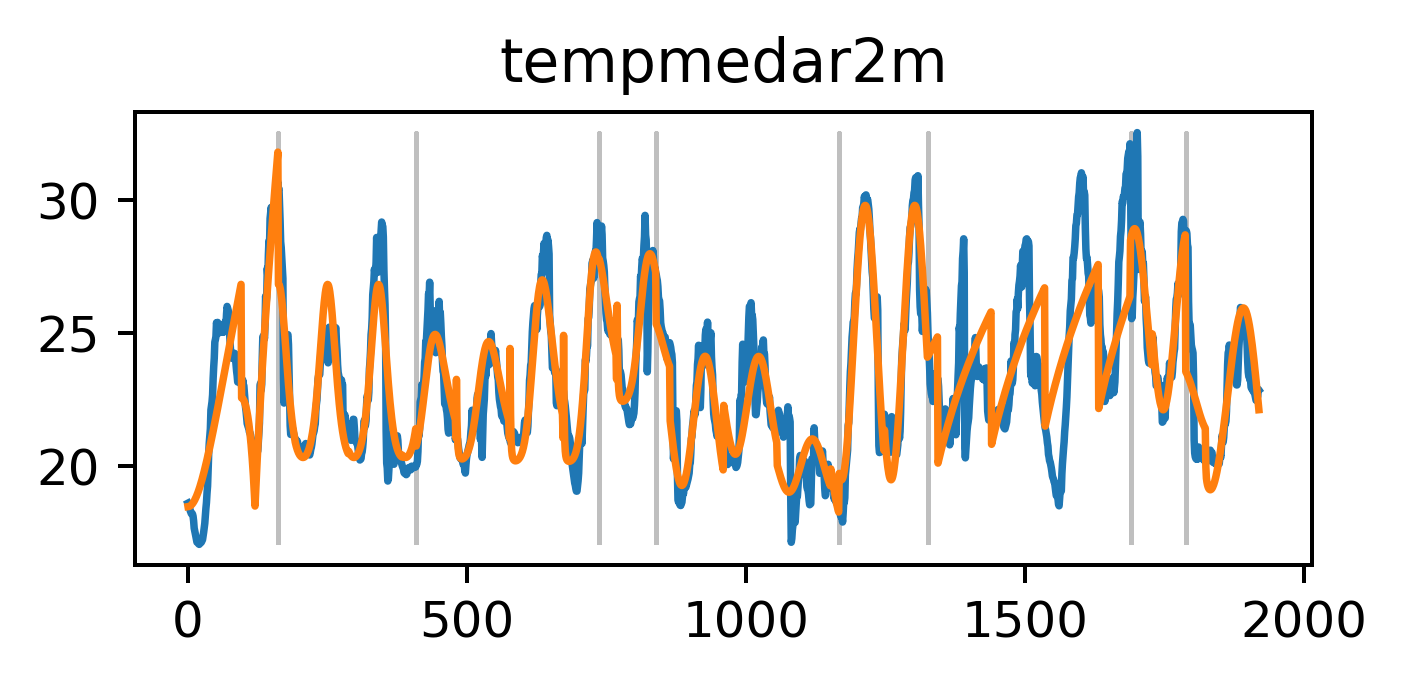

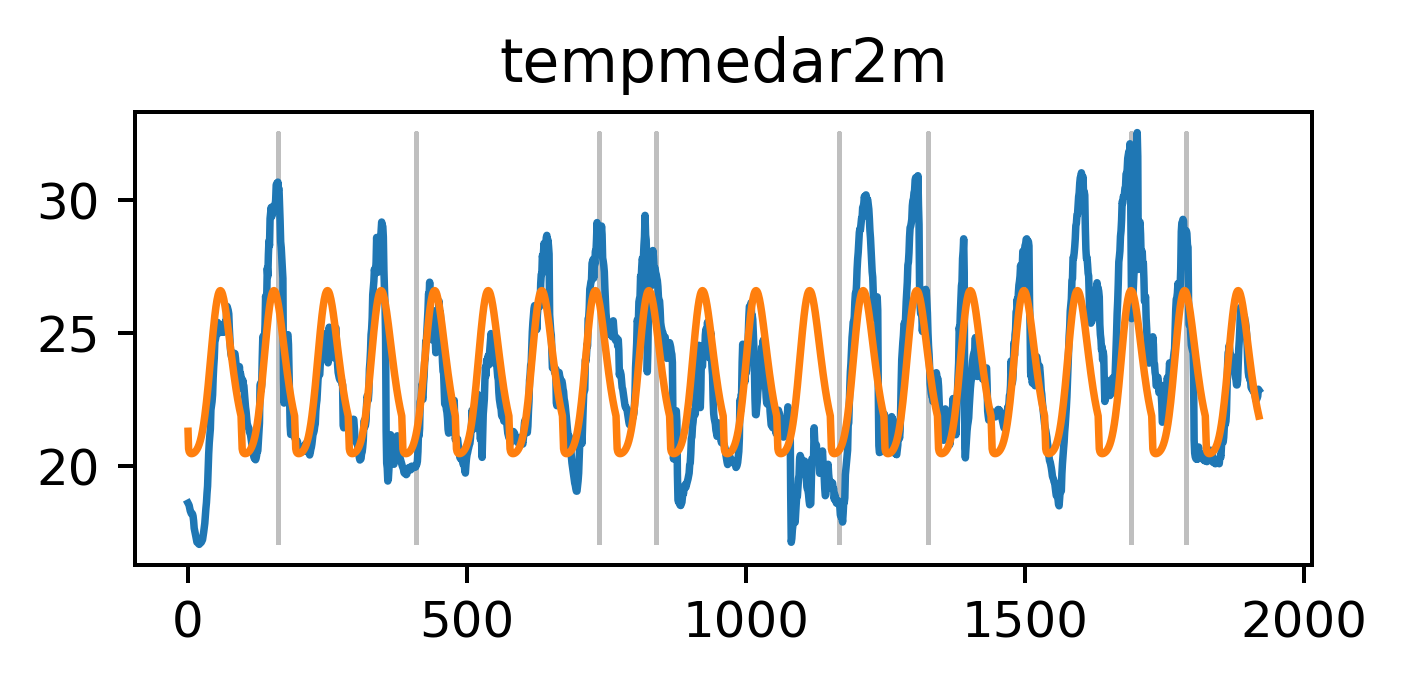

[PySRFunction(X=>18.4897459464802*(6.23145130625552e-7*Abs(1956968.2*date - hour**2*exp(exp(date))) + 1)**(1/4)), PySRFunction(X=>2.76631220706963*exp(sin(0.8330191*hour - 0.8330191*log(date))) + 19.317942), PySRFunction(X=>(date + sin(sqrt(exp(date))))**sin(hour**0.30393305) + 20.064524), PySRFunction(X=>exp(sin(hour**0.30321738))**1.7436154 + 22.272064), PySRFunction(X=>-date + sin(3.375193*date) - sin(0.84277236*hour)/Abs(sin(date)) + 31.572989), PySRFunction(X=>24.652216 - 5.15506034900274*sin(0.5363881*date + 0.0049350313*hour)), PySRFunction(X=>5.37818382717043*sqrt(date*sqrt(0.0011952463617896*hour + 1))), PySRFunction(X=>3.40291454185847*sin(103.835335989248*sqrt(9.27490895053756e-5*hour + 1)) + 25.528996), PySRFunction(X=>-sin(1.051061**(sqrt(hour)) - date)/Abs(sin(exp(date))) + 22.537704)]


In [19]:
full_series_pred = full_series_model.predict(series[['date', 'hour']])

cut_series_pred = np.concatenate([model.predict(series) for model, series in zip(cut_series_models, cut_series)])

plot(series[feature], sec_plots=[cut_series_pred], divisions=xtstree.cut_points(), title=feature)

plot(series[feature], sec_plots=[full_series_model.predict(series[['date', 'hour']])], divisions=xtstree.cut_points(), title=feature)

print([model.get_best()['lambda_format'] for model in cut_series_models])
# tree_pred_series = []
# err_mean = 0
# for pred, err in tree_predictions:
#   tree_pred_series += pred
#   err_mean += err

# err_mean = err_mean/len(tree_predictions)